Eval scripts adapted from https://github.com/SpaceNetChallenge/utilities/tree/master/python

In [1]:
import numpy as np
import geopandas as gpd
import rtree

from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from tqdm import tqdm

In [2]:
def create_rtree_from_poly(poly_list):
    # create index
    index = rtree.index.Index(interleaved=False)
    for idx, building in enumerate(poly_list):
        minx, miny, maxx, maxy = building.bounds
        envelope = (minx, maxx, miny, maxy)
        index.insert(idx, envelope)

    return index

def search_rtree(test_building, index):
    # input test poly ogr.Geometry  and rtree index
    if test_building.type == 'Polygon' or \
                    test_building.type == 'MultiPolygon':
        minx, miny, maxx, maxy = test_building.bounds
        envelope = (minx, maxx, miny, maxy)    
        fidlist = index.intersection(envelope)
    else:
        fidlist = []

    return fidlist


In [3]:
def iou(test_poly, truth_polys, truth_index=[]):
    fidlistArray = []
    iou_list = []
    
    if truth_index:
        fidlist = search_rtree(test_poly, truth_index)

        for fid in fidlist:
            if not test_poly.is_valid:
                test_poly = test_poly.buffer(0.0)

            intersection_result = test_poly.intersection(truth_polys[fid].buffer(0.0))
            fidlistArray.append(fid)

            if intersection_result.type == 'Polygon' or \
                            intersection_result.type == 'MultiPolygon':
                intersection_area = intersection_result.area
                union_area = test_poly.union(truth_polys[fid].buffer(0.0)).area
                iou_list.append(intersection_area / union_area)

            else:
                iou_list.append(0)

    else:
        for idx, truth_poly in enumerate(truth_polys):
            if not test_poly.is_valid or not truth_poly.is_valid:
                test_poly = test_poly.buffer(0.0)
                truth_poly = truth_poly.buffer(0.0)
#                 print(f'fixed geom error at {idx}')

            intersection_result = test_poly.intersection(truth_poly)
            #print(idx, intersection_result.type)

            if intersection_result.type == 'Polygon' or \
                            intersection_result.type == 'MultiPolygon':
                intersection_area = intersection_result.area
                union_area = test_poly.union(truth_poly).area
                iou_list.append(intersection_area / union_area)
    #             print(f'found intersect at test_poly {i} with truth poly {idx}')
    #             print(intersection_area/union_area)
            else:    
                iou_list.append(0)
                
    return iou_list, fidlistArray

In [4]:
def score(test_polys, truth_polys, threshold=0.5, truth_index=[],
          resultGeoJsonName = [],
          imageId = []):

    # Define internal functions

    # Find detections using threshold/argmax/IoU for test polygons
    true_pos_count = 0
    false_pos_count = 0
    truth_poly_count = len(truth_polys)
    
    true_ids = []
    false_ids = []

    for idx, test_poly in tqdm(enumerate(test_polys)):
        if truth_polys:
            iou_list, fidlist = iou(test_poly, truth_polys, truth_index)
            if not iou_list:
                maxiou = 0
            else:
                maxiou = np.max(iou_list)

#             print(maxiou, iou_list, fidlist)
            if maxiou >= threshold:
                true_pos_count += 1
                true_ids.append(idx)
                minx, miny, maxx, maxy = truth_polys[fidlist[np.argmax(iou_list)]].bounds
                envelope = (minx, maxx, miny, maxy)   
                truth_index.delete(fidlist[np.argmax(iou_list)], envelope)
                #del truth_polys[fidlist[np.argmax(iou_list)]]
            else:
                false_pos_count += 1
                false_ids.append(idx)
        else:
            false_pos_count += 1
            false_ids.append(idx)

    false_neg_count = truth_poly_count - true_pos_count

    return true_pos_count, false_pos_count, false_neg_count, true_ids, false_ids

In [5]:
def evalfunction(image_id, test_polys, truth_polys, truth_index=[], resultGeoJsonName=[], threshold = 0.5):

    if len(truth_polys)==0:
        true_pos_count = 0
        false_pos_count = len(test_polys)
        false_neg_count = 0
    else:
        true_pos_count, false_pos_count, false_neg_count, true_ids, false_ids = score(test_polys, truth_polys,
                                                                 truth_index=truth_index,
                                                                 resultGeoJsonName=resultGeoJsonName,
                                                                 imageId=image_id,
                                                                 threshold=threshold
                                                                 )


    if (true_pos_count > 0):

        precision = float(true_pos_count) / (float(true_pos_count) + float(false_pos_count))
        recall = float(true_pos_count) / (float(true_pos_count) + float(false_neg_count))
        F1score = 2.0 * precision * recall / (precision + recall)
    else:
        F1score = 0
    return ((F1score, true_pos_count, false_pos_count, false_neg_count), true_ids, false_ids, image_id)

In [6]:
def precision_recall(true_pos_count, false_pos_count, false_neg_count):
    precision = float(true_pos_count) / (float(true_pos_count) + float(false_pos_count))
    recall = float(true_pos_count) / (float(true_pos_count) + float(false_neg_count))
    return (precision, recall)

In [7]:
TRUTH = Path('znz-input')
TEST = Path('znz-20190118')

In [95]:
df_truth = gpd.read_file(f'{str(TRUTH)}/grid_042.geojson')
df_test = gpd.read_file(f'{str(TEST)}/grid_042_20190118_07_classes.geojson')

In [96]:
df_truth.head()

,id,changeset,problemati,condition,area,geometry
0,1,2017-09-03T23:40:59,None,Complete,16.93017578125,POLYGON ((39.33633038681167 -5.920836943343485...
1,2,2017-09-03T23:40:59,None,Complete,21.62890625,"POLYGON ((39.33628382960306 -5.92092792350677,..."
2,3,2017-09-03T23:40:59,None,Complete,11.2216796875,POLYGON ((39.33622587109281 -5.920941122736775...
3,4,2017-09-03T23:40:59,None,Complete,46.849609375,POLYGON ((39.33368444829663 -5.923518950659385...
4,5,2017-09-03T23:40:59,None,Complete,7.458984375,POLYGON ((39.33414129839756 -5.923375141989136...


In [97]:
df_test.head()

,cat,building_id,conf_foundation,conf_completed,conf_unfinished,geometry
0,conf_completed,0,0.0049,0.9765,0.0185,POLYGON ((39.33541308434184 -5.933007141989886...
1,conf_completed,1,0.0096,0.6228,0.3669,POLYGON ((39.33543994125422 -5.932787098088375...
2,conf_completed,2,0.0062,0.9525,0.0408,POLYGON ((39.33536607110349 -5.932866080282638...
3,conf_completed,3,0.0189,0.9730,0.0079,POLYGON ((39.33511558848227 -5.932883043772769...
4,conf_foundation,4,0.8673,0.0280,0.1034,POLYGON ((39.33529523898535 -5.932884091309337...


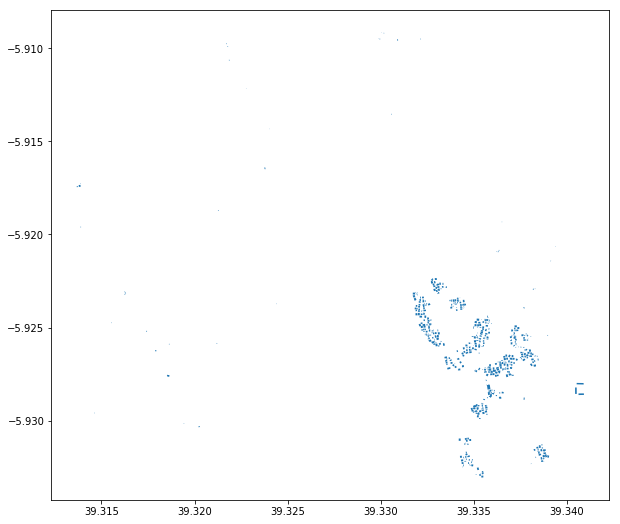

In [98]:
df_truth.geometry.plot(figsize=(10,10))

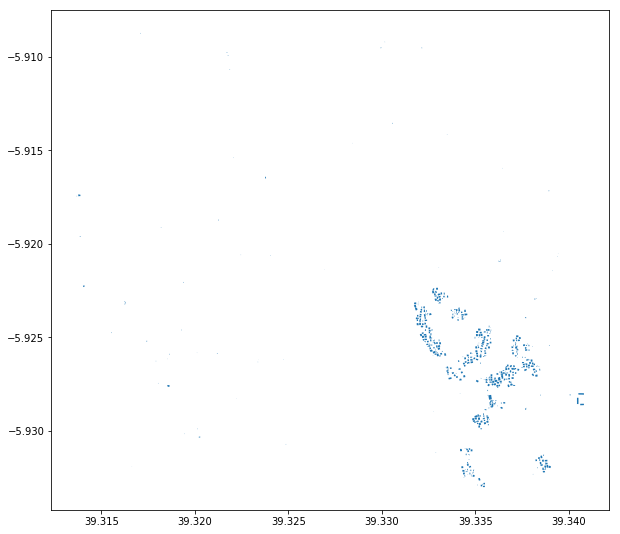

In [99]:
df_test.geometry.plot(figsize=(10,10))

In [100]:
df_test['cat'].value_counts()

conf_completed     365
conf_unfinished    108
conf_foundation     51
Name: cat, dtype: int64

In [101]:
df_truth['condition'].value_counts()

Complete      373
Incomplete    112
Foundation     66
Name: condition, dtype: int64

In [102]:
cats = [('conf_foundation','Foundation'),('conf_unfinished','Incomplete'),('conf_completed','Complete')]

In [103]:
for (test_cat, truth_cat) in cats:
    test_polys = [geom for geom in df_test[df_test['cat'] == test_cat].geometry]
    truth_polys = [geom for geom in df_truth[df_truth['condition'] == truth_cat].geometry]
    truth_index = create_rtree_from_poly(truth_polys)
    scores = evalfunction(grid_num,test_polys, truth_polys, truth_index=truth_index)
    print(truth_cat)
    print(scores[0],precision_recall(*scores[0][1:]))

51it [00:00, 372.86it/s]
35it [00:00, 346.39it/s]

Foundation
(0.717948717948718, 42, 9, 24) (0.8235294117647058, 0.6363636363636364)


108it [00:00, 394.50it/s]
50it [00:00, 493.64it/s]

Incomplete
(0.7545454545454546, 83, 25, 29) (0.7685185185185185, 0.7410714285714286)


365it [00:00, 442.09it/s]

Complete
(0.7100271002710028, 262, 103, 111) (0.7178082191780822, 0.7024128686327078)


In [104]:
test_polys = [geom for geom in df_test.geometry]
truth_polys = [geom for geom in df_truth.geometry]
truth_index = create_rtree_from_poly(truth_polys)

In [105]:
scores = evalfunction(grid_num,test_polys, truth_polys, truth_index=truth_index)
scores[0],precision_recall(*scores[0][1:])

524it [00:01, 380.99it/s]


((0.7962790697674418, 428, 96, 123), (0.816793893129771, 0.7767695099818511))